In [1]:
pip install numpy scipy matplotlib scikit-learn pandas seaborn networkx plotly bokeh jupyter ipywidgets numba pillow

  Using cached fqdn-1.5.1-py3-none-any.whl.metadata (1.4 kB)
  Using cached isoduration-20.11.0-py3-none-any.whl.metadata (5.7 kB)
  Using cached uri_template-1.3.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached webcolors-24.11.1-py3-none-any.whl.metadata (2.2 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
def visualize_thermal_map(env, grid_size=50, save_path=None):
    """Render thermal heatmap as a separate figure."""
    power_grid = env.calculate_power_grid(grid_size=grid_size)
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    extent = [0, env.chip_width, 0, env.chip_height]
    if power_grid.size > 0 and power_grid.max() > 0:
        im = ax.imshow(power_grid[::-1, :], extent=extent, origin='lower', cmap='hot', aspect='auto')
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Power Density (W/μm²)', rotation=90)
    ax.set_xlim(0, env.chip_width)
    ax.set_ylim(0, env.chip_height)
    ax.set_aspect('equal')
    ax.set_title('Thermal Map (Power Density)', fontsize=14, fontweight='bold')
    ax.set_xlabel('X coordinate (μm)')
    ax.set_ylabel('Y coordinate (μm)')
    ax.grid(True, alpha=0.2)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Thermal map saved to: {save_path}")
    plt.show()


🚀 VLSI Floorplanning RL

Circuit source:
1. Generate example circuit (default)
2. Manually enter circuit
Random circuit created: circuit.json (10 blocks, util≈48.10% on 481x386)
Circuit loaded: 10 blocks on 481x386 chip

🎛️  VLSI Floorplanning Options:
1. Use existing model (default)
2. Force retrain model
📁 Loading existing model...
Model loaded from vlsi_model.pkl
✅ Model loaded successfully!
🎯 Generating optimal solution...
✅ Solution generated: 8/8 blocks placed
📏 Total wirelength: 2495.5μm
📊 Area utilization: 43.27%

📊 DETAILED BLOCK INFORMATION

🏗️  CHIP OVERVIEW:
   Chip Dimensions: 481 × 386 μm
   Chip Area: 185,666 μm²
   Blocks Placed: 8/8
   Area Utilization: 43.27%
   Total Wirelength: 2495.5 μm
   Max Power Density: 2.29 W/mm²
   Avg Power Density: 0.76 W/mm²

📦 INDIVIDUAL BLOCK DETAILS:

🔸 BLOCK 1 - PLACED ✅
📐 DIMENSIONS:
   ├─ Width: 49 μm
   ├─ Height: 83 μm
   ├─ Area: 4,067 μm²
   └─ Aspect Ratio: 0.59
📍 POSITION:
   ├─ Bottom-Left Corner: (24, 288)
   ├─ Top-Right Co

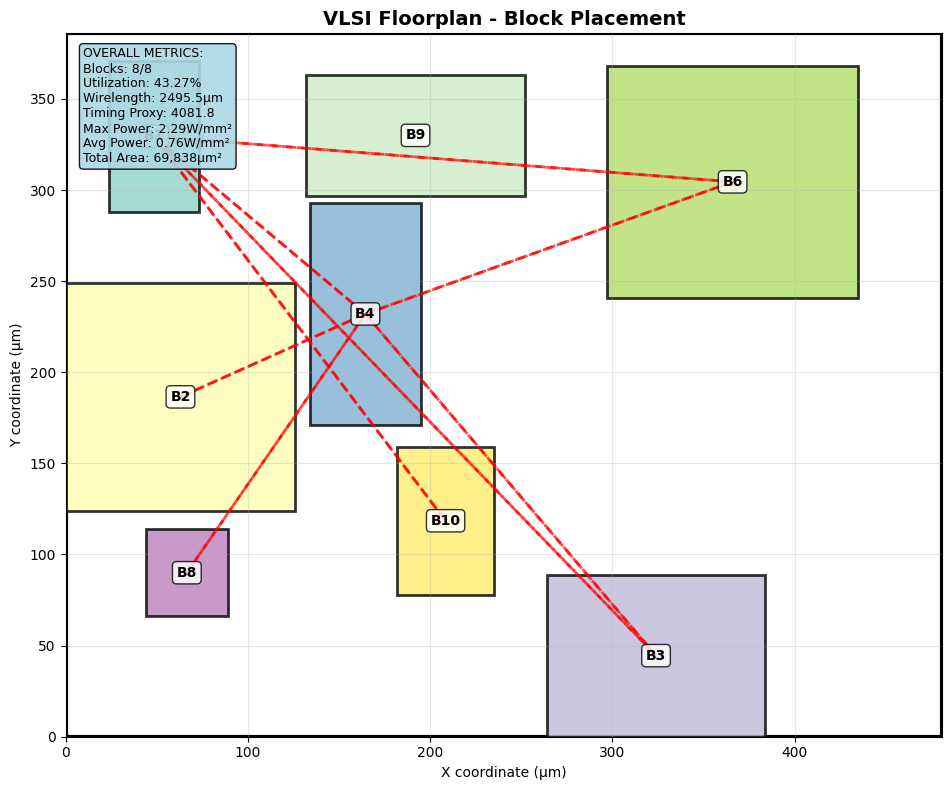

Thermal map saved to: thermal_map.png


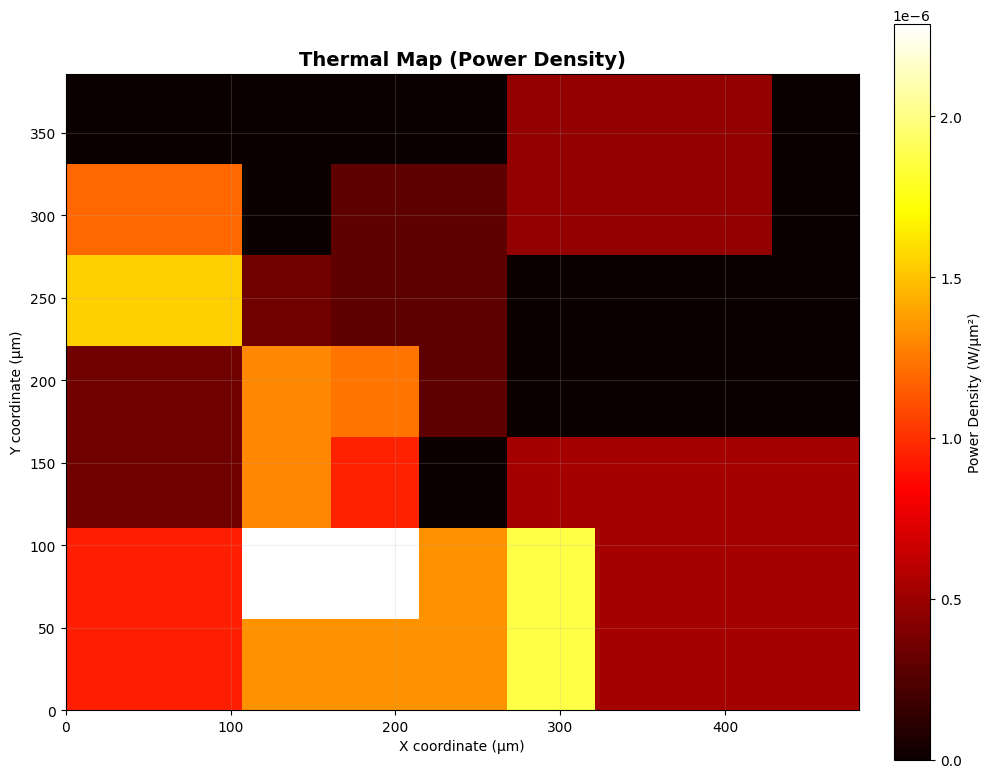

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random
from dataclasses import dataclass
from typing import List, Tuple, Dict
import json
import pickle
import os  # Added for file existence check

@dataclass
class Block:
    """VLSI block with properties"""
    id: int
    width: int
    height: int
    x: int = -1
    y: int = -1
    is_fixed: bool = False
    power_density: float = 1.0
    connections: List[int] = None
    
    def __post_init__(self):
        if self.connections is None:
            self.connections = []
    
    def area(self):
        return self.width * self.height
    
    def is_placed(self):
        return self.x >= 0 and self.y >= 0

@dataclass
class ConstraintWeights:
    """Constraint penalty weights"""
    overlap_penalty: float = -1000.0
    boundary_penalty: float = -500.0
    area_weight: float = -1.0
    wirelength_weight: float = -2.0
    timing_weight: float = -3.0
    power_weight: float = -1.5
    thermal_weight: float = -2.5

class VLSIEnvironment:
    """VLSI Floorplanning Environment"""
    
    def __init__(self, chip_width, chip_height, blocks, weights=None):
        self.chip_width = chip_width
        self.chip_height = chip_height
        self.blocks = {block.id: block for block in blocks}
        self.weights = weights or ConstraintWeights()
        self.placed_blocks = set()
        self.reset()
    
    def reset(self):
        """Reset to initial state"""
        self.placed_blocks = set()
        for block in self.blocks.values():
            if not block.is_fixed:
                block.x = -1
                block.y = -1
            else:
                self.placed_blocks.add(block.id)
        return self.get_state()
    
    def get_state(self):
        """Get current state"""
        grid_resolution = 20
        grid_w = self.chip_width // grid_resolution
        grid_h = self.chip_height // grid_resolution
        occupancy_grid = np.zeros((grid_h, grid_w))
        
        for block_id in self.placed_blocks:
            block = self.blocks[block_id]
            x_start = block.x // grid_resolution
            y_start = block.y // grid_resolution
            x_end = min(grid_w, (block.x + block.width) // grid_resolution + 1)
            y_end = min(grid_h, (block.y + block.height) // grid_resolution + 1)
            occupancy_grid[y_start:y_end, x_start:x_end] = 1
        
        unplaced_count = len(self.blocks) - len(self.placed_blocks)
        return {
            'grid': occupancy_grid.flatten(),
            'unplaced': unplaced_count,
            'placed_blocks': list(self.placed_blocks)
        }
    
    def get_valid_actions(self, block_id):
        """Get valid positions for block"""
        if block_id in self.placed_blocks:
            return []
        
        block = self.blocks[block_id]
        valid_positions = []
        step_size = max(10, min(block.width, block.height) // 2)
        
        for x in range(0, self.chip_width - block.width + 1, step_size):
            for y in range(0, self.chip_height - block.height + 1, step_size):
                if self.is_valid_placement(block_id, x, y):
                    valid_positions.append((x, y))
        
        return valid_positions
    
    def is_valid_placement(self, block_id, x, y):
        """Check if placement is valid"""
        block = self.blocks[block_id]
        
        # Boundary check
        if x + block.width > self.chip_width or y + block.height > self.chip_height:
            return False
        
        # Overlap check
        for placed_id in self.placed_blocks:
            placed_block = self.blocks[placed_id]
            if self.blocks_overlap(block, x, y, placed_block):
                return False
        
        return True
    
    def blocks_overlap(self, block1, x1, y1, block2):
        """Check overlap between blocks"""
        return not (x1 + block1.width <= block2.x or 
                   block2.x + block2.width <= x1 or
                   y1 + block1.height <= block2.y or 
                   block2.y + block2.height <= y1)
    
    def step(self, action):
        """Execute placement action"""
        block_id, x, y = action
        
        if block_id in self.placed_blocks:
            return self.get_state(), -100, False
        
        # Place block
        self.blocks[block_id].x = x
        self.blocks[block_id].y = y
        self.placed_blocks.add(block_id)
        
        # Calculate reward
        reward = self.calculate_reward()
        
        # Check if done
        done = len(self.placed_blocks) == len([b for b in self.blocks.values() if not b.is_fixed])
        
        return self.get_state(), reward, done
    
    def calculate_reward(self):
        """Calculate total reward"""
        reward = 0
        
        # Area utilization
        total_area = sum(block.area() for block in self.blocks.values())
        bounding_box_area = self.calculate_bounding_box_area()
        if bounding_box_area > 0:
            utilization = total_area / bounding_box_area
            reward += self.weights.area_weight * (1 - utilization)
        
        # Wirelength
        wirelength = self.calculate_wirelength()
        reward += self.weights.wirelength_weight * wirelength / 1000
        
        # Power density penalty (thermal proxy)
        max_power = self.calculate_max_power_density()
        reward += self.weights.power_weight * max_power
        
        # Timing proxy penalty (encourage shorter critical interconnect)
        timing_proxy = self.calculate_timing_proxy()
        reward += self.weights.timing_weight * (timing_proxy / 1000.0)
        
        # Overlap penalty: count overlaps among placed blocks
        placed_ids = list(self.placed_blocks)
        overlap_count = 0
        for i in range(len(placed_ids)):
            bi = self.blocks[placed_ids[i]]
            for j in range(i + 1, len(placed_ids)):
                bj = self.blocks[placed_ids[j]]
                if self.blocks_overlap(bi, bi.x, bi.y, bj):
                    overlap_count += 1
        reward += self.weights.overlap_penalty * overlap_count
        
        # Boundary penalty: count blocks extending beyond chip bounds
        boundary_count = 0
        for bid in placed_ids:
            b = self.blocks[bid]
            if b.x < 0 or b.y < 0 or b.x + b.width > self.chip_width or b.y + b.height > self.chip_height:
                boundary_count += 1
        reward += self.weights.boundary_penalty * boundary_count
        
        return reward
    
    def calculate_bounding_box_area(self):
        """Calculate bounding box area"""
        if not self.placed_blocks:
            return 1
        
        min_x = min(self.blocks[bid].x for bid in self.placed_blocks)
        max_x = max(self.blocks[bid].x + self.blocks[bid].width for bid in self.placed_blocks)
        min_y = min(self.blocks[bid].y for bid in self.placed_blocks)
        max_y = max(self.blocks[bid].y + self.blocks[bid].height for bid in self.placed_blocks)
        
        return (max_x - min_x) * (max_y - min_y)
    
    def calculate_wirelength(self):
        """Calculate total wirelength"""
        total_wirelength = 0
        
        for block in self.blocks.values():
            if not block.is_placed():
                continue
                
            block_center_x = block.x + block.width / 2
            block_center_y = block.y + block.height / 2
            
            for connected_id in block.connections:
                if connected_id in self.placed_blocks:
                    conn_block = self.blocks[connected_id]
                    conn_center_x = conn_block.x + conn_block.width / 2
                    conn_center_y = conn_block.y + conn_block.height / 2
                    
                    distance = abs(block_center_x - conn_center_x) + abs(block_center_y - conn_center_y)
                    total_wirelength += distance
        
        return total_wirelength / 2
    
    def calculate_max_power_density(self):
        """Calculate maximum power density"""
        grid_size = 50
        power_grid = defaultdict(float)
        
        for block in self.blocks.values():
            if not block.is_placed():
                continue
            
            for x in range(block.x, block.x + block.width, grid_size):
                for y in range(block.y, block.y + block.height, grid_size):
                    grid_x, grid_y = x // grid_size, y // grid_size
                    power_grid[(grid_x, grid_y)] += block.power_density
        
        return max(power_grid.values()) if power_grid else 0

    def calculate_power_grid(self, grid_size=50):
        """Return power grid (2D numpy array) for thermal visualization and metrics"""
        grid_w = max(1, self.chip_width // grid_size)
        grid_h = max(1, self.chip_height // grid_size)
        grid = np.zeros((grid_h, grid_w), dtype=float)
        for block in self.blocks.values():
            if not block.is_placed():
                continue
            x0 = block.x // grid_size
            y0 = block.y // grid_size
            x1 = (block.x + block.width) // grid_size
            y1 = (block.y + block.height) // grid_size
            for gy in range(y0, min(grid_h, y1 + 1)):
                for gx in range(x0, min(grid_w, x1 + 1)):
                    grid[gy, gx] += block.power_density
        return grid

    def calculate_timing_proxy(self):
        """Compute a simple timing proxy: weighted wirelength with degree-based criticality"""
        # Build degrees on placed subgraph
        degrees = defaultdict(int)
        edges = []
        for b in self.blocks.values():
            if not b.is_placed():
                continue
            for j in b.connections:
                if j in self.placed_blocks and b.id < j:
                    edges.append((b.id, j))
                    degrees[b.id] += 1
                    degrees[j] += 1
        if not edges:
            return 0.0
        max_deg = max(degrees.values()) if degrees else 1
        timing = 0.0
        for u, v in edges:
            bu = self.blocks[u]
            bv = self.blocks[v]
            du = degrees[u]
            dv = degrees[v]
            w = 1.0 + 0.5 * ((du + dv) / max_deg)
            cxu = bu.x + bu.width / 2
            cyu = bu.y + bu.height / 2
            cxv = bv.x + bv.width / 2
            cyv = bv.y + bv.height / 2
            dist = abs(cxu - cxv) + abs(cyu - cyv)
            timing += w * dist
        return timing

    def get_detailed_metrics(self):
        """Get detailed performance metrics"""
        placed_blocks = [self.blocks[bid] for bid in self.placed_blocks]
        total_area = sum(block.area() for block in placed_blocks)
        bounding_box_area = self.calculate_bounding_box_area()
        utilization = total_area / bounding_box_area if bounding_box_area > 0 else 0
        wirelength = self.calculate_wirelength()
        max_power_density = self.calculate_max_power_density()
        avg_power_density = sum(block.power_density for block in placed_blocks) / len(placed_blocks) if placed_blocks else 0
        
        return {
            'placed_count': len(self.placed_blocks),
            'total_count': len([b for b in self.blocks.values() if not b.is_fixed]),
            'utilization': utilization,
            'wirelength': wirelength,
            'total_area': total_area,
            'bounding_box_area': bounding_box_area,
            'max_power_density': max_power_density,
            'avg_power_density': avg_power_density
        }

class QLearningAgent:
    """Q-Learning agent"""
    
    def __init__(self, learning_rate=0.1, discount_factor=0.95, epsilon=0.1):
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.q_table = defaultdict(lambda: defaultdict(float))
    
    def get_state_key(self, state):
        """Convert state to key"""
        grid_hash = hash(tuple(state['grid']))
        return (grid_hash, state['unplaced'])
    
    def choose_action(self, state, valid_actions):
        """Choose action using epsilon-greedy"""
        if not valid_actions or random.random() < self.epsilon:
            return random.choice(valid_actions) if valid_actions else None
        
        state_key = self.get_state_key(state)
        best_action = None
        best_q = float('-inf')
        
        for action in valid_actions:
            q_value = self.q_table[state_key][str(action)]
            if q_value > best_q:
                best_q = q_value
                best_action = action
        
        return best_action if best_action else random.choice(valid_actions)
    
    def update_q_table(self, state, action, reward, next_state):
        """Update Q-table"""
        state_key = self.get_state_key(state)
        next_state_key = self.get_state_key(next_state)
        action_key = str(action)
        
        max_next_q = max(self.q_table[next_state_key].values()) if self.q_table[next_state_key] else 0
        
        current_q = self.q_table[state_key][action_key]
        self.q_table[state_key][action_key] = current_q + self.lr * (
            reward + self.gamma * max_next_q - current_q
        )
    
    def save_model(self, filepath):
        """Save model"""
        with open(filepath, 'wb') as f:
            pickle.dump(dict(self.q_table), f)
        print(f"Model saved to {filepath}")
    
    def load_model(self, filepath):
        """Load model"""
        try:
            with open(filepath, 'rb') as f:
                q_data = pickle.load(f)
                self.q_table = defaultdict(lambda: defaultdict(float))
                for state_key, actions in q_data.items():
                    for action_key, q_value in actions.items():
                        self.q_table[state_key][action_key] = q_value
            print(f"Model loaded from {filepath}")
            return True
        except Exception as e:
            print(f"Error loading model: {e}")
            return False

def train_agent(env, agent, episodes=500):
    """Train the RL agent"""
    episode_rewards = []
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        
        while True:
            unplaced_blocks = [bid for bid in env.blocks.keys() 
                             if bid not in env.placed_blocks and not env.blocks[bid].is_fixed]
            
            if not unplaced_blocks:
                break
            
            block_id = random.choice(unplaced_blocks)
            valid_positions = env.get_valid_actions(block_id)
            
            if not valid_positions:
                break
            
            valid_actions = [(block_id, x, y) for x, y in valid_positions]
            action = agent.choose_action(state, valid_actions)
            
            if not action:
                break
            
            next_state, reward, done = env.step(action)
            total_reward += reward
            
            agent.update_q_table(state, action, reward, next_state)
            state = next_state
            
            if done:
                break
        
        episode_rewards.append(total_reward)
        
        if episode % 100 == 0:
            agent.epsilon = max(0.01, agent.epsilon * 0.95)
            print(f"Episode {episode}, Avg Reward: {np.mean(episode_rewards[-50:]):.2f}")
    
    return episode_rewards

def display_block_details(env):
    """Display detailed block information with comprehensive individual block details"""
    print("\n" + "="*80)
    print("📊 DETAILED BLOCK INFORMATION")
    print("="*80)
    
    # Overall metrics
    metrics = env.get_detailed_metrics()
    
    print(f"\n🏗️  CHIP OVERVIEW:")
    print(f"   Chip Dimensions: {env.chip_width} × {env.chip_height} μm")
    print(f"   Chip Area: {env.chip_width * env.chip_height:,} μm²")
    print(f"   Blocks Placed: {metrics['placed_count']}/{metrics['total_count']}")
    print(f"   Area Utilization: {metrics['utilization']:.2%}")
    print(f"   Total Wirelength: {metrics['wirelength']:.1f} μm")
    # Convert internal W/μm² to W/mm² for display
    print(f"   Max Power Density: {metrics['max_power_density']*1e6:.2f} W/mm²")
    print(f"   Avg Power Density: {metrics['avg_power_density']*1e6:.2f} W/mm²")
    
    # INDIVIDUAL BLOCK DETAILS - DETAILED VIEW
    print(f"\n📦 INDIVIDUAL BLOCK DETAILS:")
    print("="*80)

    sorted_blocks = sorted(env.blocks.values(), key=lambda b: b.id)

    for block in sorted_blocks:
        status_icon = "✅" if block.is_placed() else "❌"
        status_text = "PLACED" if block.is_placed() else "UNPLACED"
        
        print(f"\n" + "="*50)
        print(f"🔸 BLOCK {block.id} - {status_text} {status_icon}")
        print("="*50)
        
        # DIMENSIONS
        print(f"📐 DIMENSIONS:")
        print(f"   ├─ Width: {block.width} μm")
        print(f"   ├─ Height: {block.height} μm")
        print(f"   ├─ Area: {block.area():,} μm²")
        print(f"   └─ Aspect Ratio: {block.width/block.height:.2f}")
        
        # POSITION
        print(f"📍 POSITION:")
        if block.is_placed():
            print(f"   ├─ Bottom-Left Corner: ({block.x}, {block.y})")
            print(f"   ├─ Top-Right Corner: ({block.x + block.width}, {block.y + block.height})")
            print(f"   ├─ Center Point: ({block.x + block.width//2}, {block.y + block.height//2})")
            print(f"   ├─ X Range: [{block.x}, {block.x + block.width}]")
            print(f"   ├─ Y Range: [{block.y}, {block.y + block.height}]")
            
            # Check boundaries
            at_boundaries = []
            if block.x == 0: at_boundaries.append("LEFT")
            if block.y == 0: at_boundaries.append("BOTTOM")
            if block.x + block.width == env.chip_width: at_boundaries.append("RIGHT")
            if block.y + block.height == env.chip_height: at_boundaries.append("TOP")
            
            if at_boundaries:
                print(f"   ├─ At Chip Boundaries: {', '.join(at_boundaries)}")
            else:
                print(f"   ├─ Position Type: Interior placement")
            
            # Area usage
            chip_area = env.chip_width * env.chip_height
            area_percentage = (block.area() / chip_area) * 100
            print(f"   └─ Chip Area Usage: {area_percentage:.2f}%")
        else:
            print(f"   └─ Status: NOT PLACED YET")
        
        # POWER DETAILS
        print(f"⚡ POWER:")
        total_power_w = block.area() * block.power_density  # W (since power_density is W/μm²)
        
        # Classify based on W/mm² visualized density
        pd_mm2 = block.power_density * 1e6
        if pd_mm2 > 1.2:
            power_level = "🔥 HIGH POWER"
            power_risk = "CRITICAL"
        elif pd_mm2 > 0.8:
            power_level = "⚠️  MEDIUM POWER"
            power_risk = "MODERATE"
        else:
            power_level = "✅ LOW POWER"
            power_risk = "SAFE"
        
        print(f"   ├─ Power Density: {pd_mm2:.2f} W/mm²")
        print(f"   ├─ Total Power Consumption: {total_power_w*1e3:.1f} mW")
        print(f"   ├─ Power Level: {power_level}")
        print(f"   └─ Thermal Risk: {power_risk}")
        
        # CONNECTION DETAILS
        print(f"🔗 CONNECTIONS:")
        if block.connections:
            print(f"   ├─ Total Connections: {len(block.connections)}")
            print(f"   ├─ Connected Block IDs: {block.connections}")
            
            if block.is_placed():
                print(f"   ├─ Connection Analysis:")
                total_wire_length = 0
                for i, conn_id in enumerate(block.connections):
                    if conn_id in env.placed_blocks:
                        conn_block = env.blocks[conn_id]
                        # Calculate center-to-center distance
                        block_center_x = block.x + block.width / 2
                        block_center_y = block.y + block.height / 2
                        conn_center_x = conn_block.x + conn_block.width / 2
                        conn_center_y = conn_block.y + conn_block.height / 2
                        
                        dist_x = abs(block_center_x - conn_center_x)
                        dist_y = abs(block_center_y - conn_center_y)
                        manhattan_dist = dist_x + dist_y
                        euclidean_dist = (dist_x**2 + dist_y**2)**0.5
                        
                        total_wire_length += manhattan_dist
                        
                        prefix = "   │   ├─" if i < len(block.connections) - 1 else "   │   └─"
                        print(f"{prefix} To Block {conn_id}:")
                        print(f"   │       ├─ Manhattan Distance: {manhattan_dist:.1f} μm")
                        print(f"   │       ├─ Euclidean Distance: {euclidean_dist:.1f} μm")
                        print(f"   │       ├─ X Separation: {dist_x:.1f} μm")
                        print(f"   │       └─ Y Separation: {dist_y:.1f} μm")
                    else:
                        prefix = "   │   ├─" if i < len(block.connections) - 1 else "   │   └─"
                        print(f"{prefix} To Block {conn_id}: NOT PLACED YET")
                
                print(f"   └─ Total Wire Length from this block: {total_wire_length:.1f} μm")
            else:
                print(f"   └─ Connection distances: Cannot calculate (block not placed)")
        else:
            print(f"   └─ No connections to other blocks")
        
        # BLOCK PROPERTIES
        print(f"🔧 BLOCK PROPERTIES:")
        print(f"   ├─ Block ID: {block.id}")
        print(f"   ├─ Fixed Position: {'YES (cannot be moved)' if block.is_fixed else 'NO (can be moved)'}")
        print(f"   ├─ Block Type: {'Fixed Block' if block.is_fixed else 'Movable Block'}")
        
        if block.is_placed():
            # Calculate distance from chip center
            chip_center_x = env.chip_width / 2
            chip_center_y = env.chip_height / 2
            block_center_x = block.x + block.width / 2
            block_center_y = block.y + block.height / 2
            distance_from_center = ((block_center_x - chip_center_x)**2 + (block_center_y - chip_center_y)**2)**0.5
            print(f"   ├─ Distance from Chip Center: {distance_from_center:.1f} μm")
            
            # Placement quality metrics
            edge_distance = min(block.x, block.y, env.chip_width - (block.x + block.width), env.chip_height - (block.y + block.height))
            print(f"   ├─ Distance to Nearest Edge: {edge_distance} μm")
            
            placement_efficiency = (block.area() / ((block.width + 20) * (block.height + 20))) * 100
            print(f"   └─ Placement Efficiency: {placement_efficiency:.1f}%")
        else:
            print(f"   └─ Placement Status: PENDING")

    # CONNECTION ANALYSIS
    print(f"\n🔗 OVERALL CONNECTION ANALYSIS:")
    total_connections = sum(len(block.connections) for block in env.blocks.values()) // 2
    active_connections = 0
    
    connection_details = []
    for block in env.blocks.values():
        if block.is_placed():
            for conn_id in block.connections:
                if conn_id in env.placed_blocks and block.id < conn_id:
                    conn_block = env.blocks[conn_id]
                    distance = abs((block.x + block.width/2) - (conn_block.x + conn_block.width/2)) + \
                              abs((block.y + block.height/2) - (conn_block.y + conn_block.height/2))
                    connection_details.append((block.id, conn_id, distance))
                    active_connections += 1
    
    print(f"   Total Potential Connections: {total_connections}")
    print(f"   Active Connections: {active_connections}")
    success_rate = (active_connections/total_connections*100) if total_connections > 0 else 0
    print(f"   Connection Success Rate: {success_rate:.1f}%")
    
    if connection_details:
        print("\n   📏 Active Connection Details:")
        for i, (block1_id, block2_id, distance) in enumerate(sorted(connection_details, key=lambda x: x[2])):
            print(f"   {i+1:2d}. Block {block1_id} ↔ Block {block2_id}: {distance:.1f} μm")

    # POWER ANALYSIS
    print(f"\n⚡ OVERALL POWER ANALYSIS:")
    placed_blocks = [block for block in env.blocks.values() if block.is_placed()]
    if placed_blocks:
        total_power = sum(block.area() * block.power_density for block in placed_blocks)
        print(f"   Total Power Consumption: {total_power*1e3:.1f} mW")
        print(f"   Average Power Density: {metrics['avg_power_density']*1e6:.2f} W/mm²")
        print(f"   Peak Power Density: {metrics['max_power_density']*1e6:.2f} W/mm²")
        
        power_blocks = [(block.id, block.power_density, block.area() * block.power_density) for block in placed_blocks]
        power_blocks.sort(key=lambda x: x[1], reverse=True)
        
        print("\n   Power Ranking (by density):")
        for i, (block_id, density_w_um2, total_pwr_w) in enumerate(power_blocks):
            density_w_mm2 = density_w_um2 * 1e6
            status = "🔥 HIGH" if density_w_mm2 > 1.2 else "⚠️  MED" if density_w_mm2 > 0.8 else "✅ LOW"
            print(f"   {i+1:2d}. Block {block_id}: {density_w_mm2:.2f} W/mm² ({total_pwr_w*1e3:.1f} mW total) {status}")

    # SPACE EFFICIENCY
    print(f"\n📏 SPACE UTILIZATION ANALYSIS:")
    if env.placed_blocks:
        bounding_box = env.calculate_bounding_box_area()
        chip_area = env.chip_width * env.chip_height
        used_area = metrics['total_area']
        wasted_area = chip_area - used_area
        
        print(f"   Chip Total Area: {chip_area:,} μm²")
        print(f"   Used Block Area: {used_area:,} μm²")
        print(f"   Wasted Area: {wasted_area:,} μm²")
        print(f"   Area Utilization: {(used_area/chip_area):.2%}")
        print(f"   Bounding Box Area: {bounding_box:,} μm²")
        print(f"   Bounding Box Efficiency: {(used_area/bounding_box):.2%}")
    
    print("\n" + "="*80)

# Fallback: ensure thermal map drawer is defined even if earlier cell wasn't run
if 'visualize_thermal_map' not in globals():
    def visualize_thermal_map(env, grid_size=50, save_path=None):
        power_grid = env.calculate_power_grid(grid_size=grid_size)
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        extent = [0, env.chip_width, 0, env.chip_height]
        if power_grid.size > 0 and power_grid.max() > 0:
            im = ax.imshow(power_grid[::-1, :], extent=extent, origin='lower', cmap='hot', aspect='auto')
            cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            cbar.set_label('Power Density (W/μm²)', rotation=90)
        ax.set_xlim(0, env.chip_width)
        ax.set_ylim(0, env.chip_height)
        ax.set_aspect('equal')
        ax.set_title('Thermal Map (Power Density)', fontsize=14, fontweight='bold')
        ax.set_xlabel('X coordinate (μm)')
        ax.set_ylabel('Y coordinate (μm)')
        ax.grid(True, alpha=0.2)
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Thermal map saved to: {save_path}")
        plt.show()

def visualize_floorplan(env, save_path=None):
    """Visualize the floorplan (single plot, no thermal overlay)"""
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
    
    # Main floorplan visualization
    ax1.add_patch(plt.Rectangle((0, 0), env.chip_width, env.chip_height, 
                              fill=False, edgecolor='black', linewidth=3))
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(env.blocks)))
    
    # Draw blocks
    for i, (block_id, block) in enumerate(env.blocks.items()):
        if block.is_placed():
            rect = plt.Rectangle((block.x, block.y), block.width, block.height,
                               facecolor=colors[i], edgecolor='black', 
                               alpha=0.8, linewidth=2)
            ax1.add_patch(rect)
            
            # Block label
            ax1.text(block.x + block.width/2, block.y + block.height/2, 
                   f'B{block_id}', ha='center', va='center', fontweight='bold',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            # Power indicator
            if block.power_density > 2.5:
                ax1.text(block.x + 2, block.y + block.height - 8, 'HIGH', 
                       fontsize=8, color='red', fontweight='bold')
            elif block.power_density > 1.5:
                ax1.text(block.x + 2, block.y + block.height - 8, 'MED', 
                       fontsize=8, color='orange', fontweight='bold')
    
    # Draw connections
    for block in env.blocks.values():
        if not block.is_placed():
            continue
        block_center = (block.x + block.width/2, block.y + block.height/2)
        
        for conn_id in block.connections:
            if conn_id in env.placed_blocks:
                conn_block = env.blocks[conn_id]
                conn_center = (conn_block.x + conn_block.width/2, 
                             conn_block.y + conn_block.height/2)
                ax1.plot([block_center[0], conn_center[0]], 
                       [block_center[1], conn_center[1]], 
                       'r--', alpha=0.7, linewidth=2)
    
    ax1.set_xlim(0, env.chip_width)
    ax1.set_ylim(0, env.chip_height)
    ax1.set_aspect('equal')
    ax1.set_title('VLSI Floorplan - Block Placement', fontsize=14, fontweight='bold')
    ax1.set_xlabel('X coordinate (μm)')
    ax1.set_ylabel('Y coordinate (μm)')
    ax1.grid(True, alpha=0.3)
    
    # Overall metrics text
    metrics = env.get_detailed_metrics()
    timing_proxy = env.calculate_timing_proxy()
    metrics_text = f"""OVERALL METRICS:
Blocks: {metrics['placed_count']}/{metrics['total_count']}
Utilization: {metrics['utilization']:.2%}
Wirelength: {metrics['wirelength']:.1f}μm
Timing Proxy: {timing_proxy:.1f}
Max Power: {metrics['max_power_density']*1e6:.2f}W/mm²
Avg Power: {metrics['avg_power_density']*1e6:.2f}W/mm²
Total Area: {metrics['total_area']:,}μm²"""
    
    ax1.text(0.02, 0.98, metrics_text, transform=ax1.transAxes, 
            verticalalignment='top', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.9))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Visualization saved to: {save_path}")
    
    plt.show()

class UserInterface:
    """Smart user interface with model persistence"""
    
    def __init__(self, model_path="vlsi_model.pkl"):
        self.agent = QLearningAgent()
        self.current_env = None
        self.training_episodes = 500
        self.model_path = model_path
    
    def create_sample_circuit(self, filename="sample_circuit.json"):
        """Create a randomized sample circuit with realistic ranges and constraints"""
        # Random number of blocks (moderate design size)
        num_blocks = random.randint(6, 14)
        blocks = []
        
        # Generate blocks with realistic sizes and aspect ratios
        total_area = 0
        for i in range(1, num_blocks + 1):
            # Constrain width/height and aspect ratio
            width = random.randint(40, 150)
            height = random.randint(40, 150)
            # Enforce aspect ratio between 0.5 and 2.0 by resampling a side if needed
            ar = width / height
            if ar < 0.5:
                width = max(40, int(height * random.uniform(0.5, 1.2)))
            elif ar > 2.0:
                height = max(40, int(width / random.uniform(1.2, 2.0)))
            
            area = width * height
            total_area += area
            
            # Power density (realistic): specify in W/mm², store internally as W/μm²
            # Typical on-die heat flux is ~0.2–1.2 W/mm²; smaller blocks can be hotter
            size_factor = min(1.2, max(0.8, 10000 / max(1, area)))
            pd_mm2 = random.uniform(0.2, 1.2) * size_factor
            power_density = pd_mm2 * 1e-6  # convert to W/μm² for internal calculations
            
            is_fixed = random.random() < 0.2  # ~20% fixed blocks
            blocks.append({
                "id": i,
                "width": width,
                "height": height,
                "power_density": power_density,
                "is_fixed": is_fixed,
            })
        
        # Choose chip dimensions to target utilization between 40%-60%
        target_util = random.uniform(0.4, 0.6)
        chip_area = int(total_area / max(0.01, target_util))
        chip_ar = random.uniform(1.0, 1.8)
        chip_width = int((chip_area * chip_ar) ** 0.5)
        chip_height = max(1, int(chip_area / max(1, chip_width)))
        
        # Ensure all blocks fit: grow chip if needed to accommodate max block
        max_w = max(b["width"] for b in blocks)
        max_h = max(b["height"] for b in blocks)
        chip_width = max(chip_width, max_w + 20)
        chip_height = max(chip_height, max_h + 20)
        
        # Assign fixed block coordinates within bounds without overlap
        def rects_overlap(ax, ay, aw, ah, bx, by, bw, bh):
            return not (ax + aw <= bx or bx + bw <= ax or ay + ah <= by or by + bh <= ay)
        
        fixed_rects = []  # list of (x,y,w,h) for already placed fixed blocks
        for b in blocks:
            if b.get("is_fixed"):
                placed = False
                for _ in range(200):  # try multiple random placements
                    x = random.randint(0, max(0, chip_width - b["width"]))
                    y = random.randint(0, max(0, chip_height - b["height"]))
                    # check overlap against existing fixed blocks
                    if all(not rects_overlap(x, y, b["width"], b["height"], rx, ry, rw, rh)
                           for (rx, ry, rw, rh) in fixed_rects):
                        b["x"], b["y"] = x, y
                        fixed_rects.append((x, y, b["width"], b["height"]))
                        placed = True
                        break
                if not placed:
                    # fallback: mark as non-fixed if we couldn't place without overlap
                    b["is_fixed"] = False
                    b["x"] = -1
                    b["y"] = -1
            else:
                b["x"] = -1
                b["y"] = -1
        
        # Random undirected sparse connections (avg degree ~ 1-3)
        for i in range(1, num_blocks + 1):
            possible = [j for j in range(1, num_blocks + 1) if j != i]
            max_deg = random.randint(1, 3)
            k = random.randint(0, min(max_deg, len(possible)))
            conns = set(random.sample(possible, k)) if k > 0 else set()
            for j in conns:
                blocks[i-1].setdefault("connections", [])
                blocks[j-1].setdefault("connections", [])
                if j not in blocks[i-1]["connections"]:
                    blocks[i-1]["connections"].append(j)
                if i not in blocks[j-1]["connections"]:
                    blocks[j-1]["connections"].append(i)
        
        sample_data = {
            "chip": {"width": chip_width, "height": chip_height},
            "blocks": blocks
        }
        
        with open(filename, 'w') as f:
            json.dump(sample_data, f, indent=2)
        print(f"Random circuit created: {filename} ({num_blocks} blocks, util≈{total_area/(chip_width*chip_height):.2%} on {chip_width}x{chip_height})")
    
    def create_circuit_from_user_input(self):
        """Create circuit from manual user input and initialize environment"""
        try:
            print("\nManual Circuit Entry")
            chip_width = int(input("Enter chip width (μm): ").strip())
            chip_height = int(input("Enter chip height (μm): ").strip())
            num_blocks = int(input("Enter number of blocks: ").strip())
            
            blocks = []
            for i in range(1, num_blocks + 1):
                print(f"\nBlock {i}:")
                width = int(input("  Width (μm): ").strip())
                height = int(input("  Height (μm): ").strip())
                # Accept power density in W/mm² for input and convert to W/μm²
                pd_mm2_str = input("  Power density (W/mm², leave empty for 0.8): ").strip()
                pd_mm2 = float(pd_mm2_str) if pd_mm2_str else 0.8
                power_density = pd_mm2 * 1e-6
                is_fixed_str = input("  Is fixed? (y/N): ").strip().lower()
                is_fixed = is_fixed_str in ("y", "yes")
                x = y = -1
                if is_fixed:
                    x = int(input("  Fixed X position: ").strip())
                    y = int(input("  Fixed Y position: ").strip())
                # Connections as comma-separated ids
                conn_str = input("  Connections (comma-separated block ids, empty for none): ").strip()
                connections = []
                if conn_str:
                    try:
                        connections = [int(v) for v in conn_str.split(',') if v.strip() != ""]
                    except Exception:
                        print("  Invalid connections list, defaulting to none.")
                        connections = []
                blocks.append(Block(id=i, width=width, height=height, power_density=power_density,
                                    connections=connections, is_fixed=is_fixed, x=x, y=y))
            
            self.current_env = VLSIEnvironment(chip_width, chip_height, blocks)
            print(f"Manual circuit created: {num_blocks} blocks on {chip_width}x{chip_height} chip")
            return True
        except Exception as e:
            print(f"Error during manual circuit entry: {e}")
            return False
    
    def load_circuit(self, filepath):
        """Load circuit from JSON file"""
        try:
            with open(filepath, 'r') as f:
                data = json.load(f)
            
            blocks = []
            for b in data['blocks']:
                block = Block(
                    id=b['id'], width=b['width'], height=b['height'],
                    power_density=b.get('power_density', 1.0),
                    connections=b.get('connections', []),
                    is_fixed=b.get('is_fixed', False),
                    x=b.get('x', -1), y=b.get('y', -1)
                )
                blocks.append(block)
            
            chip_width = data['chip']['width']
            chip_height = data['chip']['height']
            
            self.current_env = VLSIEnvironment(chip_width, chip_height, blocks)
            print(f"Circuit loaded: {len(blocks)} blocks on {chip_width}x{chip_height} chip")
            return True
            
        except Exception as e:
            print(f"Error loading circuit: {e}")
            return False
    
    def load_or_train_model(self, force_retrain=False):
        """Smart model loading - train only if needed"""
        if force_retrain or not os.path.exists(self.model_path):
            if force_retrain:
                print("🔄 Force retraining requested...")
            else:
                print("🆕 No existing model found. Training new model...")
            return self.train_model(save_path=self.model_path)
        else:
            print("📁 Loading existing model...")
            success = self.agent.load_model(self.model_path)
            if success:
                print("✅ Model loaded successfully!")
                return True
            else:
                print("❌ Failed to load model. Training new one...")
                return self.train_model(save_path=self.model_path)
    
    def train_model(self, save_path=None):
        """Train the model"""
        if not self.current_env:
            print("No circuit loaded!")
            return False
        
        print(f"🚂 Training for {self.training_episodes} episodes...")
        rewards = train_agent(self.current_env, self.agent, episodes=self.training_episodes)
        
        if save_path:
            self.agent.save_model(save_path)
        
        print("✅ Training completed!")
        return True
    
    def generate_solution(self):
        """Generate floorplan solution"""
        if not self.current_env:
            print("No circuit loaded!")
            return False
        
        print("🎯 Generating optimal solution...")
        state = self.current_env.reset()
        self.agent.epsilon = 0  # Greedy policy for best solution
        
        while True:
            unplaced_blocks = [bid for bid in self.current_env.blocks.keys() 
                             if bid not in self.current_env.placed_blocks and 
                             not self.current_env.blocks[bid].is_fixed]
            if not unplaced_blocks:
                break
            
            # Randomize placement order to diversify arrangements
            random.shuffle(unplaced_blocks)
            block_id = unplaced_blocks[0]
            
            valid_positions = self.current_env.get_valid_actions(block_id)
            if not valid_positions:
                break
            
            # Randomize candidate positions before action selection
            random.shuffle(valid_positions)
            valid_actions = [(block_id, x, y) for x, y in valid_positions]
            action = self.agent.choose_action(state, valid_actions)
            
            if not action:
                break
            
            state, reward, done = self.current_env.step(action)
            
            if done:
                break
        
        # Show results
        metrics = self.current_env.get_detailed_metrics()
        print(f"✅ Solution generated: {metrics['placed_count']}/{metrics['total_count']} blocks placed")
        print(f"📏 Total wirelength: {metrics['wirelength']:.1f}μm")
        print(f"📊 Area utilization: {metrics['utilization']:.2%}")
        
        # Always display full block details immediately
        display_block_details(self.current_env)
        
        return True
    
    def run_interactive_session(self):
        """Interactive session with options"""
        print("\n🎛️  VLSI Floorplanning Options:")
        print("1. Use existing model (default)")
        print("2. Force retrain model")
        
        choice = input("\nEnter choice (1-2) or press Enter for default: ").strip()
        
        if choice == "2":
            return self.load_or_train_model(force_retrain=True)
        else:  # Default and '1'
            return self.load_or_train_model(force_retrain=False)

def run_cli():
    """Command-line interface for generating or manually entering circuits"""
    print("🚀 VLSI Floorplanning RL")
    print("=" * 32)
    
    ui = UserInterface()
    
    # Choose circuit source
    print("\nCircuit source:")
    print("1. Generate example circuit (default)")
    print("2. Manually enter circuit")
    choice = input("Choose 1 or 2 (press Enter for default): ").strip()
    
    if choice == "2":
        if not ui.create_circuit_from_user_input():
            return
    else:
        # Generate and load example
        ui.create_sample_circuit("circuit.json")
        if not ui.load_circuit("circuit.json"):
            print("❌ Failed to load circuit!")
            return
    
    # Model handling
    if not ui.run_interactive_session():
        return
    
    # Generate, report, and visualize
    ui.generate_solution()
    visualize_floorplan(ui.current_env, "floorplan_result.png")
    visualize_thermal_map(ui.current_env, save_path="thermal_map.png")

# Main execution
if __name__ == "__main__":
    run_cli()